In [1]:
"""
Assignment #2
Author: Matthew McFee
Student #: 1005449631
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data
def load_data():
  with np.load("notMNIST.npz") as data:
    data, targets = data["images"], data["labels"]
        
    np.random.seed(521)
    rand_idx = np.arange(len(data))
    np.random.shuffle(rand_idx)
        
    data = data[rand_idx] / 255.0
    targets = targets[rand_idx].astype(int)
        
    train_data, train_target = data[:10000], targets[:10000]
    valid_data, valid_target = data[10000:16000], targets[10000:16000]
    test_data, test_target = data[16000:], targets[16000:]

  return train_data, valid_data, test_data, train_target, valid_target, test_target

def convert_onehot(train_target, valid_target, test_target):
  new_train = np.zeros((train_target.shape[0], 10))
  new_valid = np.zeros((valid_target.shape[0], 10))
  new_test = np.zeros((test_target.shape[0], 10))

  for item in range(0, train_target.shape[0]):
    new_train[item][train_target[item]] = 1
  for item in range(0, valid_target.shape[0]):
    new_valid[item][valid_target[item]] = 1
  for item in range(0, test_target.shape[0]):
    new_test[item][test_target[item]] = 1

  return new_train, new_valid, new_test

def shuffle(data, target):
  np.random.seed(421)
  rand_idx = np.random.permutation(len(data))
  return data[rand_idx], target[rand_idx]

In [2]:
# Helper functions
def relu(x):
  """Compute the ReLU on a input array"""
  # Check where x > 0 and keep value otherwise set value to 0
  output = np.where(x > 0, x, 0)
  return output

def softmax(x):
  """Compute the softmax of a input array"""
  output = x - np.max(x, axis=1, keepdims=True) # Subtract maximum to prevent overflow
  output = np.exp(x)
  output = output / output.sum(axis=1, keepdims=True)
  return output

def compute(x, w, b):
  """Compute the forward pass"""
  output = x @ w + b
  return output

def average_ce(targets, predictions):
  """Calculate the average cross-entropy
  Probably a bug here
  """
  probs = np.log(predictions)
  inner_sum = np.sum(np.multiply(targets, probs), axis=1) # Element wise multiply target one hot
  # encoding with each probability then sum
  average_ce = -1 * np.mean(inner_sum) # Take the mean and multiply by -1
  return average_ce

def grad_ce(targets, o):
  """Compute the gradient of the cross entropy"""
  probs = softmax(o)
  diff = probs - targets
  grads = np.mean(diff, axis=0).reshape(-1, 1)
  return grads


In [3]:
def train_network(x_train, y_train, x_valid, y_valid, features_dim, 
                  hidden_dim, output_dim, learning_rate, gamma, epochs, batch_size,
                  tol):
  """
  Function that creates and trains a neural network as specified in the 
  assignment details.
  """
  # Initialize the weights to appropriate shapes and values
  scale_value_h = 2 / (features_dim + hidden_dim)
  scale_value_o = 2 / (hidden_dim + output_dim)
  # scale_value = 0
  w_h = np.random.normal(loc=0.0, scale=scale_value_h, size=(features_dim, hidden_dim))
  b_h = np.random.normal(loc=0.0, scale=0.0, size=(hidden_dim))
  w_o = np.random.normal(loc=0.0, scale=scale_value_o, size=(hidden_dim, output_dim))
  b_o = np.random.normal(loc=0.0, scale=0.0, size=(output_dim))

  # Initialize the momentum
  v_h = np.random.normal(loc=0.0, scale=0.0, size=(features_dim, hidden_dim)) + 1e-5
  v_b_h = np.random.normal(loc=0.0, scale=0.0, size=(hidden_dim)) + 1e-5
  v_o = np.random.normal(loc=0.0, scale=0.0, size=(hidden_dim, output_dim)) + 1e-5
  v_b_o = np.random.normal(loc=0.0, scale=0.0, size=(output_dim)) + 1e-5

  # Determine the number of batches
  num_batches = np.ceil(x_train.shape[0] / batch_size)

  # Initialize lists to store losses
  train_losses_list = []
  validation_losses_list = []
  train_accuracies_list = []
  validation_accuracies_list = []

  # Initialize stored loss
  valid_loss_old = np.inf
  
  # Iterate through the data 
  for epoch in range(epochs):
    # Shuffle the data each epoch
    x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)

    # Batch the data
    x_batches = np.split(x_train_shuffled, num_batches)
    y_batches = np.split(y_train_shuffled, num_batches)

    for x_batch, y_batch in zip(x_batches, y_batches):
      # Forward pass
      h = compute(x_batch, w_h, b_h)
      h = relu(h)
      o = compute(h, w_o, b_o)
      preds = softmax(o)
      diff = preds - y_batch

      # Backward pass
      do = grad_ce(y_batch, o)
      dw_o = (1 / x_batch.shape[0]) * h.T @ diff
      db_o = do.flatten()
      # Need this since gradient of ReLU is 0 or 1
      h_zeros = np.where(h > 0, 1, 0)
      part_1 = diff @ w_o.T
      part_2 = np.multiply(part_1, h_zeros)
      dw_h = (1 / x_batch.shape[0]) * x_batch.T @ part_2
      db_h = np.mean(np.multiply(diff @ w_o.T, h_zeros), axis=0)
      db_h = db_h.flatten()
      # For debugging gradients
      # dw_h = 0
      # db_h = 0
      # dw_o = 0
      # db_o = 0

      # Update the weights 
      # Standard backprop for debugging
      # w_o = w_o - learning_rate * dw_o
      # b_o = b_o - learning_rate * db_o
      # w_h = w_h - learning_rate * dw_h
      # b_h = b_h - learning_rate * db_h

      # Momentum implementation
      mom_w_o = gamma * v_o + learning_rate * dw_o
      mom_b_o = gamma * v_b_o + learning_rate * db_o
      mom_w_h = gamma * v_h + learning_rate * dw_h
      mom_b_h = gamma * v_b_h + learning_rate * db_h
      w_o = w_o - mom_w_o
      b_o = b_o - mom_b_o
      w_h = w_h - mom_w_h
      b_h = b_h - mom_b_h

    # Check loss every epoch
    train_h = compute(x_train, w_h, b_h)
    train_o = compute(train_h, w_o, b_o)
    train_preds = softmax(train_o)
    train_loss = average_ce(y_train, train_preds)
    train_losses_list.append(train_loss)
    # Calculate accuracy
    train_pred_indices = np.argmax(train_preds, axis=1)
    train_targ_indices = np.argmax(y_train, axis=1)
    train_accuracy = np.sum(train_pred_indices == train_targ_indices) / len(train_pred_indices)
    train_accuracies_list.append(train_accuracy)
    # Same for validation
    valid_h = compute(x_valid, w_h, b_h)
    valid_o = compute(valid_h, w_o, b_o)
    valid_preds = softmax(valid_o)
    valid_loss = average_ce(y_valid, valid_preds)
    validation_losses_list.append(valid_loss)
    valid_pred_indices = np.argmax(valid_preds, axis=1)
    valid_targ_indices = np.argmax(y_valid, axis=1)
    valid_accuracy = np.sum(valid_pred_indices == valid_targ_indices) / len(valid_pred_indices)
    validation_accuracies_list.append(valid_accuracy)

    # Logging
    print("Epoch", str(epoch + 1), "Train loss: ", train_loss, "Test loss: ", valid_loss)

    # Break if validation loss has converged
    if np.abs(valid_loss - valid_loss_old) <= tol:
      break
    valid_loss_old = valid_loss
  
  return w_o, b_o, w_h, b_h, train_losses_list, validation_losses_list, train_accuracies_list, validation_accuracies_list

In [4]:
# train_data, valid_data, test_data, train_target, valid_target, test_target
# Extract data
x_train, x_valid, x_test, y_train, y_valid, y_test = load_data()
x_train = x_train.reshape(-1, 28*28)
x_valid = x_valid.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [5]:
# One hot encode labels
y_train, y_valid, y_test = convert_onehot(y_train, y_valid, y_test)
y_train.shape

(10000, 10)

In [6]:
w_o, b_o, w_h, b_h, train_losses_list, validation_losses_list, train_accuracies_list, validation_accuracies_list = train_network(
    x_train, y_train, x_valid, y_valid, 784, 1000, 10, 0.1, 0.90, 200, 1000, 0.0001
)

Epoch 1 Train loss:  2.29470826739002 Test loss:  2.2951669640402295
Epoch 2 Train loss:  2.2731029604762116 Test loss:  2.2744491933730173
Epoch 3 Train loss:  2.186490535026851 Test loss:  2.19068345075039
Epoch 4 Train loss:  1.9401721640101233 Test loss:  1.9502804870073276
Epoch 5 Train loss:  1.568469193958636 Test loss:  1.5823058858713928
Epoch 6 Train loss:  1.2224169650874506 Test loss:  1.2367149032072091
Epoch 7 Train loss:  0.9906675303575244 Test loss:  1.0049513395066683
Epoch 8 Train loss:  0.8461122206314409 Test loss:  0.8603449681443044
Epoch 9 Train loss:  0.750114847856666 Test loss:  0.7644736167823412
Epoch 10 Train loss:  0.6818313571723116 Test loss:  0.6966192905571267
Epoch 11 Train loss:  0.6316182891810096 Test loss:  0.64707541056808
Epoch 12 Train loss:  0.5942261004472106 Test loss:  0.6104749017249301
Epoch 13 Train loss:  0.5660140768579277 Test loss:  0.5831010746570291
Epoch 14 Train loss:  0.5443006072015104 Test loss:  0.562244648692672
Epoch 15 Tr

In [7]:
# Debugging test
# w_o, b_o, w_h, b_h, train_losses_list, validation_losses_list = train_network(
#   x_train[:10], y_train[:10], x_valid[:10], y_valid[:10], 784, 1000, 10, 0.1, 500, 1, 0.00001
# ) 

In [8]:
# Plot loss results
plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="train")
plt.plot(range(1, len(validation_losses_list) + 1), validation_losses_list, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.savefig("loss.png", dpi=600)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot accuracy results
plt.plot(range(1, len(train_accuracies_list) + 1), train_accuracies_list, label="train")
plt.plot(range(1, len(validation_accuracies_list) + 1), validation_accuracies_list, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.png", dpi=600)
plt.clf()

<Figure size 432x288 with 0 Axes>

Epoch 1/30
10/10 [==============================] - 2s 109ms/step - loss: 1.1366 - val_loss: 0.5500
Epoch 2/30
10/10 [==============================] - 1s 92ms/step - loss: 0.5106 - val_loss: 0.4983
Epoch 3/30
10/10 [==============================] - 1s 92ms/step - loss: 0.4151 - val_loss: 0.4085
Epoch 4/30
10/10 [==============================] - 1s 91ms/step - loss: 0.3576 - val_loss: 0.3836
Epoch 5/30
10/10 [==============================] - 1s 90ms/step - loss: 0.3246 - val_loss: 0.3770
Epoch 6/30
10/10 [==============================] - 1s 90ms/step - loss: 0.2970 - val_loss: 0.3601
Epoch 7/30
10/10 [==============================] - 1s 92ms/step - loss: 0.2715 - val_loss: 0.3449
Epoch 8/30
10/10 [==============================] - 1s 91ms/step - loss: 0.2548 - val_loss: 0.3375
Epoch 9/30
10/10 [==============================] - 1s 90ms/step - loss: 0.2359 - val_loss: 0.3307
Epoch 10/30
10/10 [==============================] - 1s 90ms/step - loss: 0.2246 - val_loss: 0.3333
Epoch 11

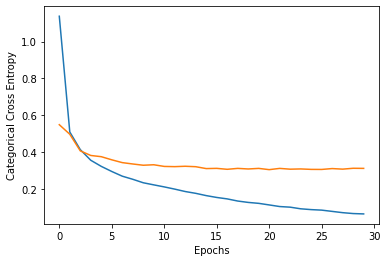

In [10]:
# Confirm my results with a Keras implementation
from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)
model = tf.keras.Sequential([tf.keras.layers.Dense(1000, activation="relu"),
                             tf.keras.layers.Dense(10, activation="softmax")])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9), loss='categorical_crossentropy')
history = model.fit(x_train, y_train, batch_size=1000, epochs=30, validation_data=(x_valid,y_valid),) # callbacks=[early_stop])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross Entropy")
plt.show()

In [11]:
# Show the model can memorize a small subset of data as a test
w_o, b_o, w_h, b_h, train_losses_list, validation_losses_list, train_accuracies_list, validation_accuracies_list = train_network(
    x_train[:10], y_train[:10], x_valid[:10], y_valid[:10], 784, 1000, 10, 0.01, 0.90, 200, 1, 0.00001
)

Epoch 1 Train loss:  2.290004066329894 Test loss:  2.302281036221862
Epoch 2 Train loss:  2.2804737043954173 Test loss:  2.302683820341611
Epoch 3 Train loss:  2.271509546304439 Test loss:  2.303215482070362
Epoch 4 Train loss:  2.262687403441994 Test loss:  2.303844254968304
Epoch 5 Train loss:  2.2538681953864135 Test loss:  2.3045234697855195
Epoch 6 Train loss:  2.244904467059709 Test loss:  2.305260734157371
Epoch 7 Train loss:  2.235554230976102 Test loss:  2.3060298514663793
Epoch 8 Train loss:  2.225346094836249 Test loss:  2.3068065683693115
Epoch 9 Train loss:  2.2135441209744173 Test loss:  2.307592802929471
Epoch 10 Train loss:  2.1987234157892175 Test loss:  2.3083035650389148
Epoch 11 Train loss:  2.178688203051416 Test loss:  2.3090585392383307
Epoch 12 Train loss:  2.1500827608883966 Test loss:  2.310057031399879
Epoch 13 Train loss:  2.1091343411221053 Test loss:  2.3120986501939575
Epoch 14 Train loss:  2.0540954277679426 Test loss:  2.3168632761516244
Epoch 15 Train 

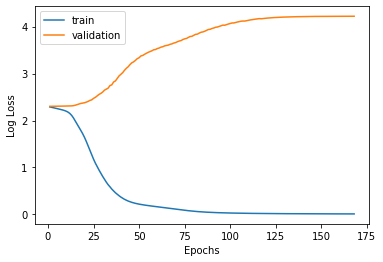

In [12]:
plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="train")
plt.plot(range(1, len(validation_losses_list) + 1), validation_losses_list, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

x_train, x_valid, y_train, y_valid = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)



In [14]:
y_train, y_valid, _ = convert_onehot(y_train, y_valid, y_valid)

In [15]:
len(y_train)

898

In [16]:
# Try the model on MNIST as another check
w_o, b_o, w_h, b_h, train_losses_list, validation_losses_list, train_accuracies_list, validation_accuracies_list = train_network(
    x_train[:800], y_train[:800], x_valid[:800], y_valid[:800], 64, 50, 10, 0.001, 0.0, 200, 10, 0.00001)

Epoch 1 Train loss:  2.198859465312759 Test loss:  2.2324639312358174
Epoch 2 Train loss:  2.049113948318569 Test loss:  2.088168898978022
Epoch 3 Train loss:  1.8709572378693426 Test loss:  1.916976783361543
Epoch 4 Train loss:  1.6689128222691165 Test loss:  1.7235256000354235
Epoch 5 Train loss:  1.4566049608593141 Test loss:  1.5207570383629148
Epoch 6 Train loss:  1.251490979374372 Test loss:  1.3252883586558142
Epoch 7 Train loss:  1.0683212491055012 Test loss:  1.1514341989777106
Epoch 8 Train loss:  0.9129422253029614 Test loss:  1.004735297240057
Epoch 9 Train loss:  0.7851074173331554 Test loss:  0.8847060376823436
Epoch 10 Train loss:  0.6816923252138222 Test loss:  0.7881310476352497
Epoch 11 Train loss:  0.5983854050338366 Test loss:  0.7106803003997753
Epoch 12 Train loss:  0.531012436566526 Test loss:  0.6485444245093299
Epoch 13 Train loss:  0.4760607739862416 Test loss:  0.5981328119905288
Epoch 14 Train loss:  0.4307133566780661 Test loss:  0.5567472618169376
Epoch 15

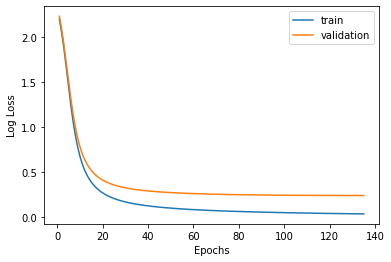

In [17]:
plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="train")
plt.plot(range(1, len(validation_losses_list) + 1), validation_losses_list, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()

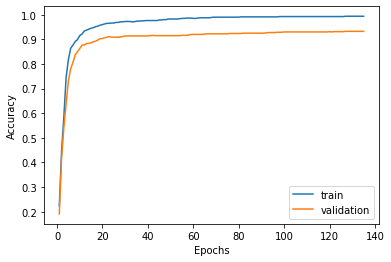

In [18]:
# Plot accuracy results
plt.plot(range(1, len(train_accuracies_list) + 1), train_accuracies_list, label="train")
plt.plot(range(1, len(validation_accuracies_list) + 1), validation_accuracies_list, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()